In [1]:
"""Import Statements"""
import fileops as fo
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [2]:
DIRECTORY_PATH = 'tspset1_heuristics/'

# Get filenames of heuristics and approximation results
heuristics = {}
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]

for filename in filenames:
    heuristics[filename.replace('.json', '')] = np.array(fo.load_from_json(DIRECTORY_PATH + filename))


## Histograms of Heuristics

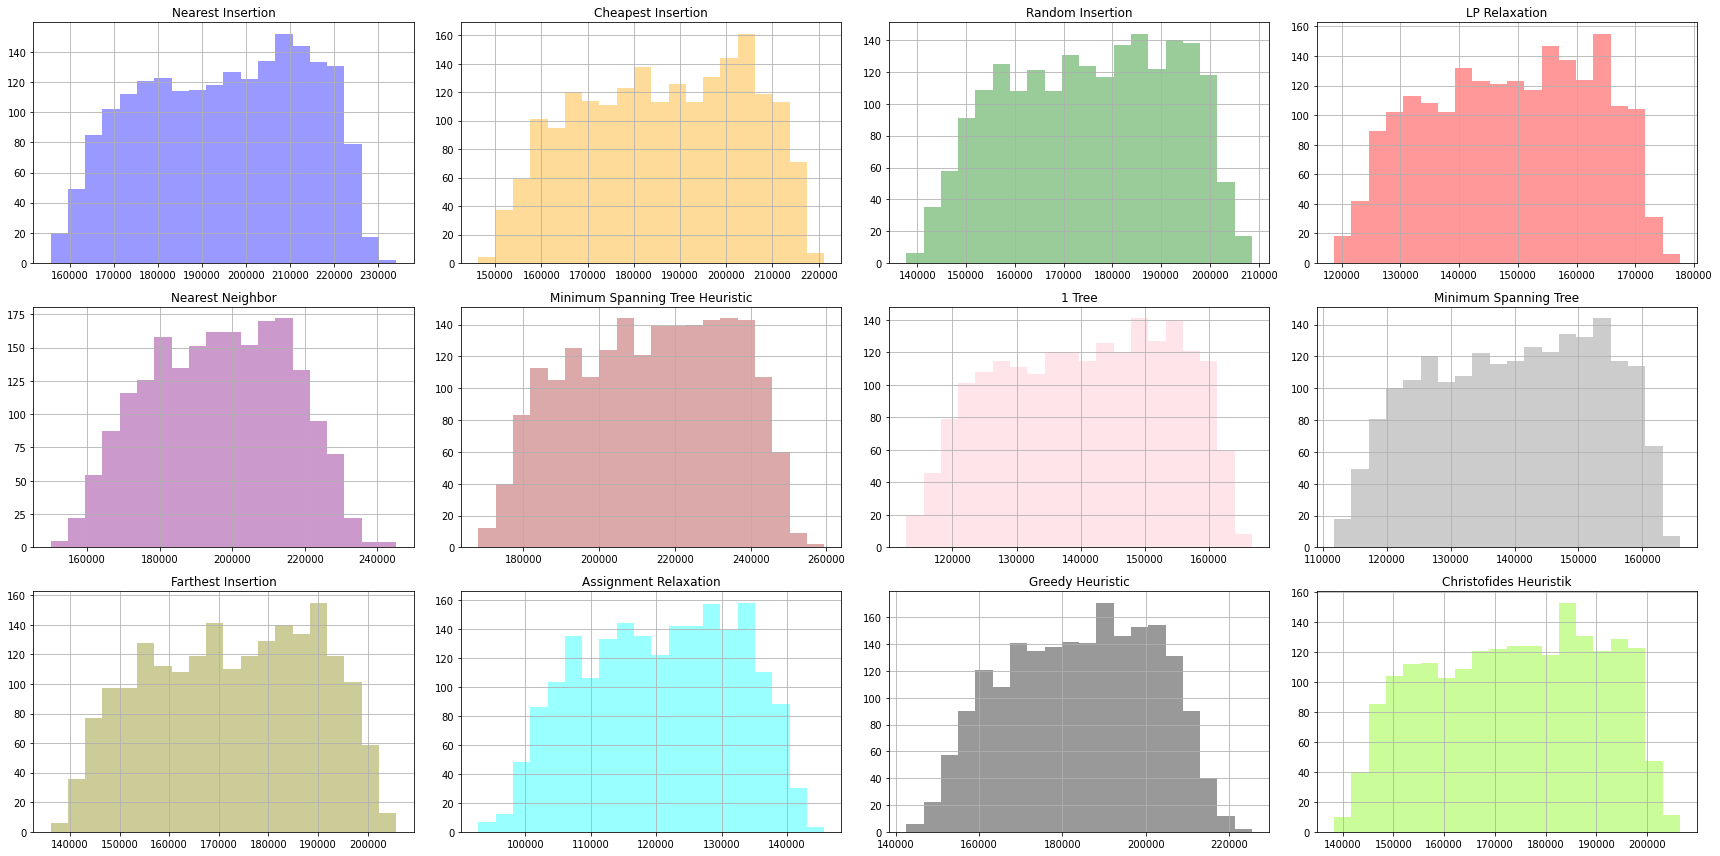

In [3]:
from visualisations import visualise_heuristics_distribution

heuristics_without_opt = heuristics.copy()
del heuristics_without_opt['opt']
visualise_heuristics_distribution(heuristics_without_opt)

## Histograms of Accuracy of Heuristics in Relation to optimal TSP-Tour

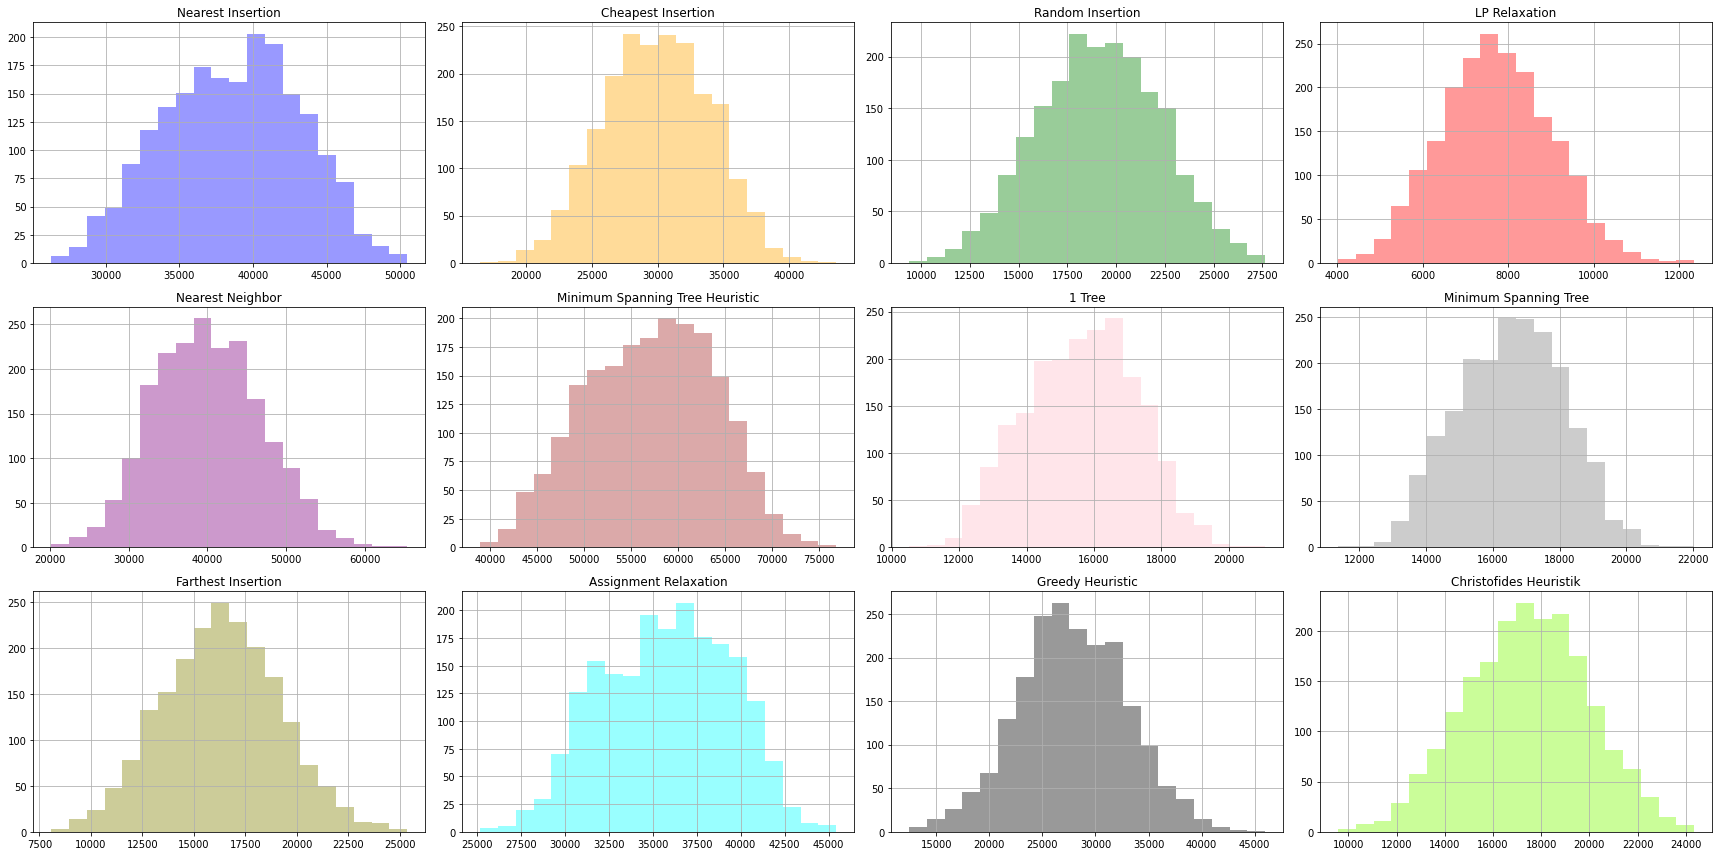

In [4]:
# Find difference of the heuristics to the optimal tour length
distances_from_opt = {}
for key, value in heuristics.items():
    if key == 'opt':
        continue
    distances_from_opt[key] = abs(heuristics['opt'] - value)

visualise_heuristics_distribution(distances_from_opt)

## Percentual deviation from optimal tour costs
Note that here negative values indicate that the heuristic is a lower bound while positive values indicate a heuristic to be an approximatio of the problem solution

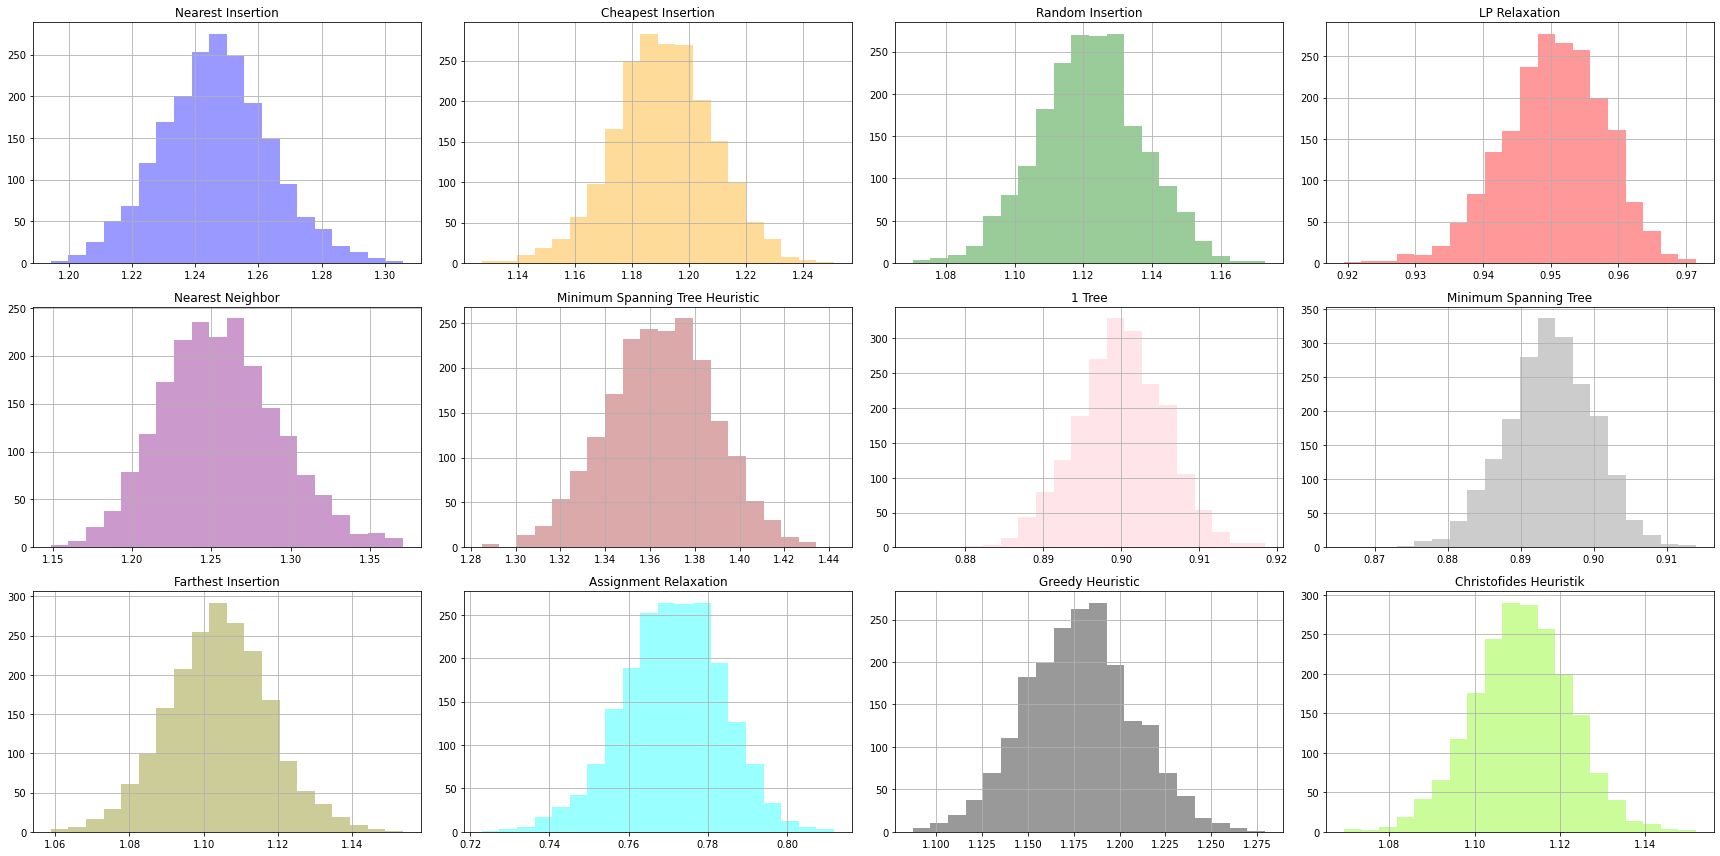

In [5]:
perc_dev_from_opt = {}
for key, value in heuristics.items():
    if key == 'opt':
        continue
    distance = heuristics['opt'] - value
    rel_distance = distance / heuristics['opt']
    perc_dev_from_opt[key] = 1 - rel_distance

visualise_heuristics_distribution(perc_dev_from_opt)

In [6]:
from visualisations import heuristic_names

devs = {}
for key, value in perc_dev_from_opt.items():
    display_name = heuristic_names[key]
    devs[display_name] = []
    devs[display_name].append(np.median(value))
    devs[display_name].append(np.mean(value))


df = pd.DataFrame(data=devs, index=['Median', 'Mean'])
display(df.drop(columns=['Assignment Relaxation', 'LP Relaxation']).T)

Median      Mean
Nearest Insertion                1.246618  1.246526
Cheapest Insertion               1.191330  1.191171
Random Insertion                 1.121979  1.121880
Nearest Neighbor                 1.254825  1.255869
Minimum Spanning Tree Heuristic  1.365463  1.364788
1 Tree                           0.899955  0.899949
Minimum Spanning Tree            0.894225  0.894054
Farthest Insertion               1.104330  1.104064
Greedy Heuristic                 1.178439  1.178128
Christofides Heuristik           1.111340  1.111159

## Visualize a Tour

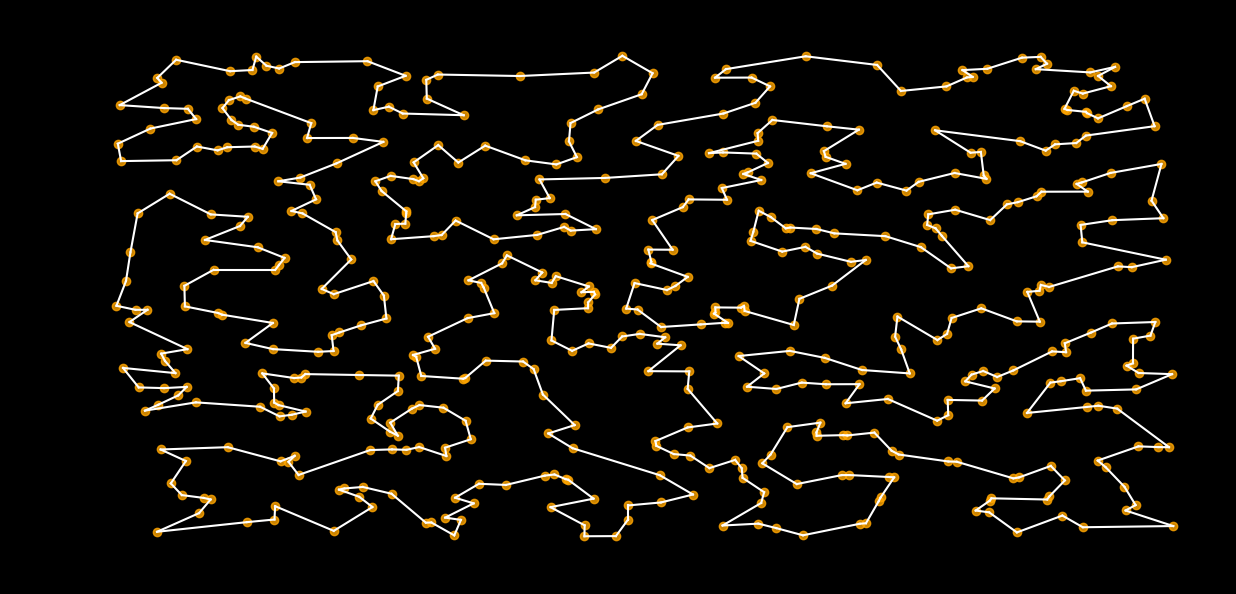

In [7]:
from visualisations import visualise_tour

instance = fo.load_from_json('tspset1/tsp_300_sol.json')

coordinates = np.array(instance['node_coordinates'])

visualise_tour(coordinates, instance['tour'], title='TSP Instance Optimal Tour')

## Heuristics and optimal Tour in relation to Graph size

In [8]:
DIRECTORY_PATH = 'tspset1'

# Get a list of filenames in the directory (excluding subdirectories)
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]

# Sort filenames
filenames.sort(key = lambda name: int(name.replace('tsp_', '').replace('_sol.json','')))

# Read data into memory
instances = []
for filename in filenames:
    instance = fo.load_from_json(DIRECTORY_PATH + '/' + filename)
    instances.append(instance)

In [9]:
# delete illegal heuristics
del heuristics['assrel']
del heuristics['lplb']
del heuristics['ci']

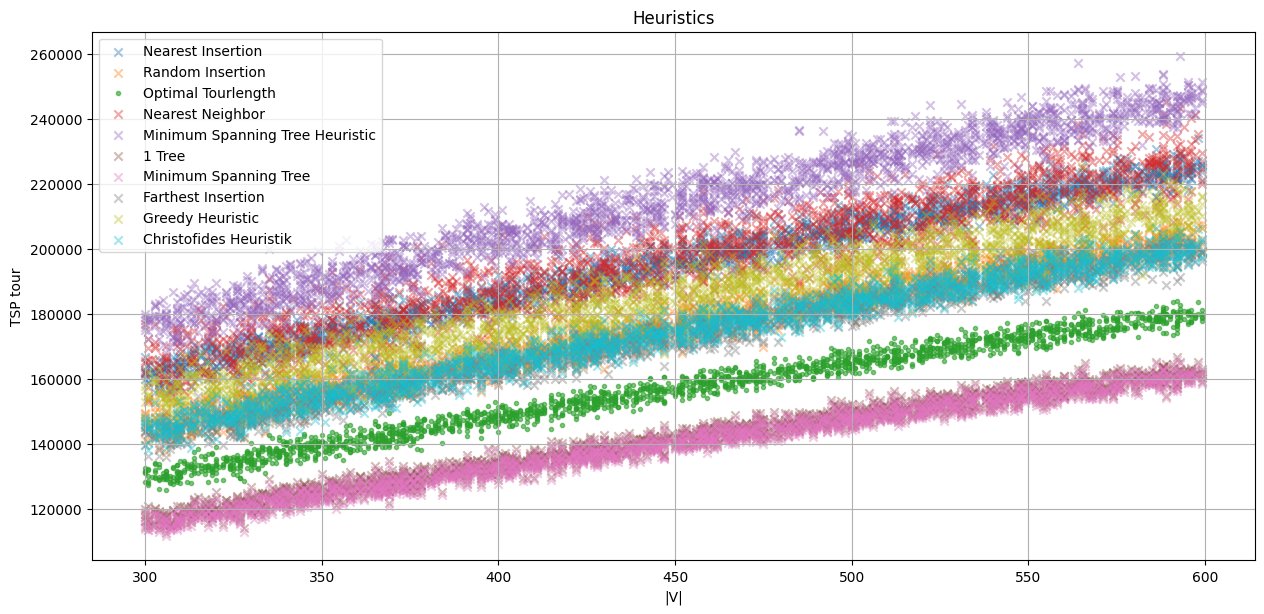

In [10]:
from visualisations import visualise_heuristics

V = [len(x['node_coordinates']) for x in instances]

visualise_heuristics(heuristics, V)

## Regression models trained on the data from the heuristics

In [99]:
# moving into DataFrame structure
df_heuristics = pd.DataFrame(heuristics)

# splitting data
X = df_heuristics.drop(columns=['opt'])
y = df_heuristics['opt']

### Multiple Linear Regression

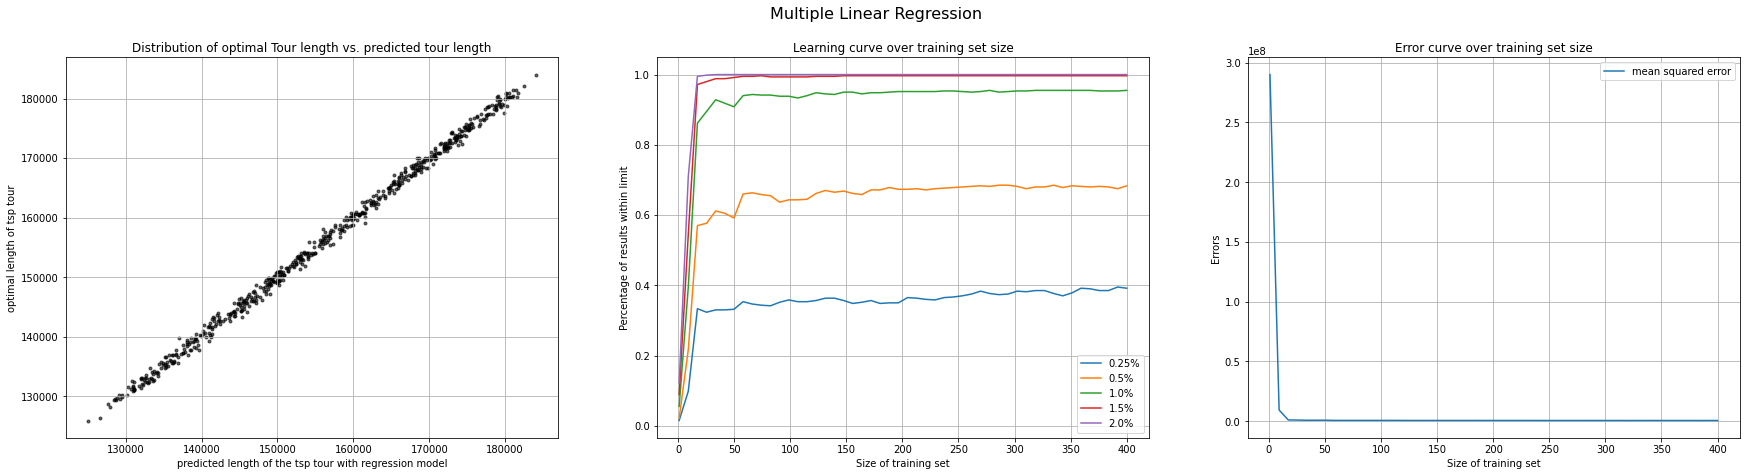

r2_value : 0.9973507491144844


In [104]:
import regressions.regression as rg
from visualisations import visualise_regression
from sklearn.metrics import r2_score

train_set_size, results, errors = rg.get_instances(limits=[0.0025, 0.005, 0.01, 0.015, 0.02])

model = LinearRegression()

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)
del errors['mean_absolute_error']
visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Multiple Linear Regression')

print('r2_value :', r2_score(y_verify, predictions))

### Regression Tree

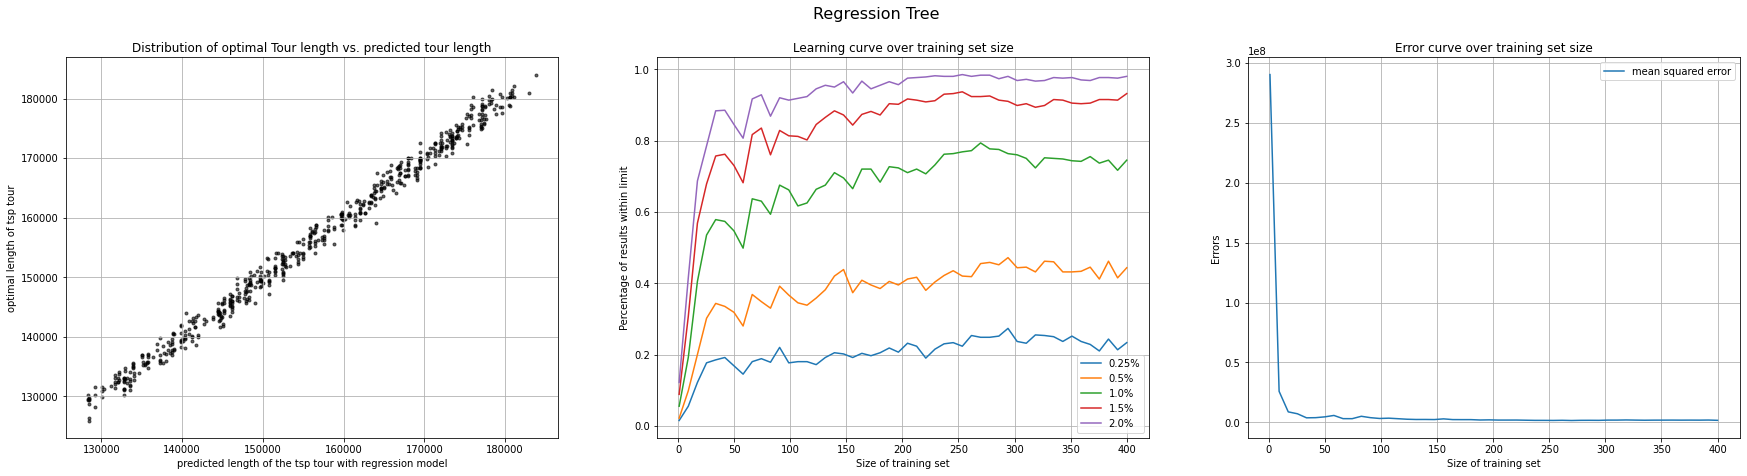

r2_value : 0.9920000023111225


In [105]:
train_set_size, results, errors = rg.get_instances(limits=[0.0025, 0.005, 0.01, 0.015, 0.02])

model = DecisionTreeRegressor()

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)
del errors['mean_absolute_error']
visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Regression Tree')
print('r2_value :', r2_score(y_verify, predictions))

### Neural Network Regression

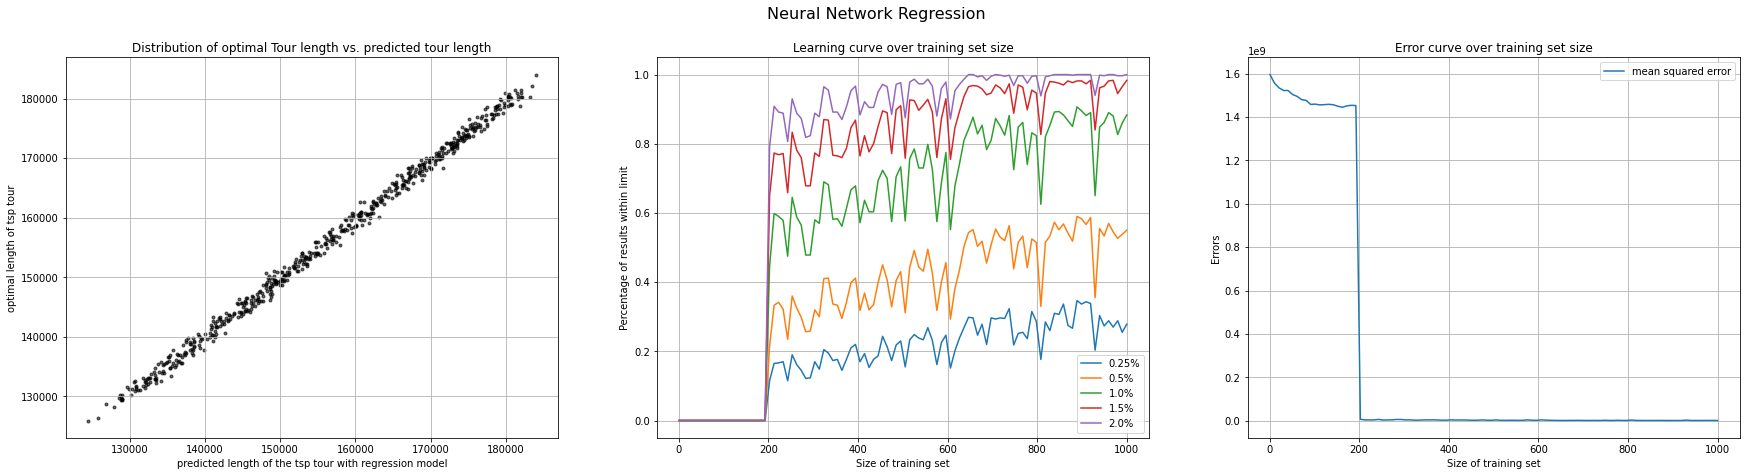

r2_value : 0.9953478258897611


In [109]:
import warnings
warnings.filterwarnings('ignore')

train_set_size, results, errors = rg.get_instances(limits=[0.0025, 0.005, 0.01, 0.015, 0.02], partition_of_data_set=1/2, number_of_sets=100)

model = MLPRegressor(hidden_layer_sizes=256,random_state=101)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors, test_size=0.3)
del errors['mean_absolute_error']
visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Neural Network Regression')
print('r2_value :', r2_score(y_verify, predictions))

### Support Vector Regression

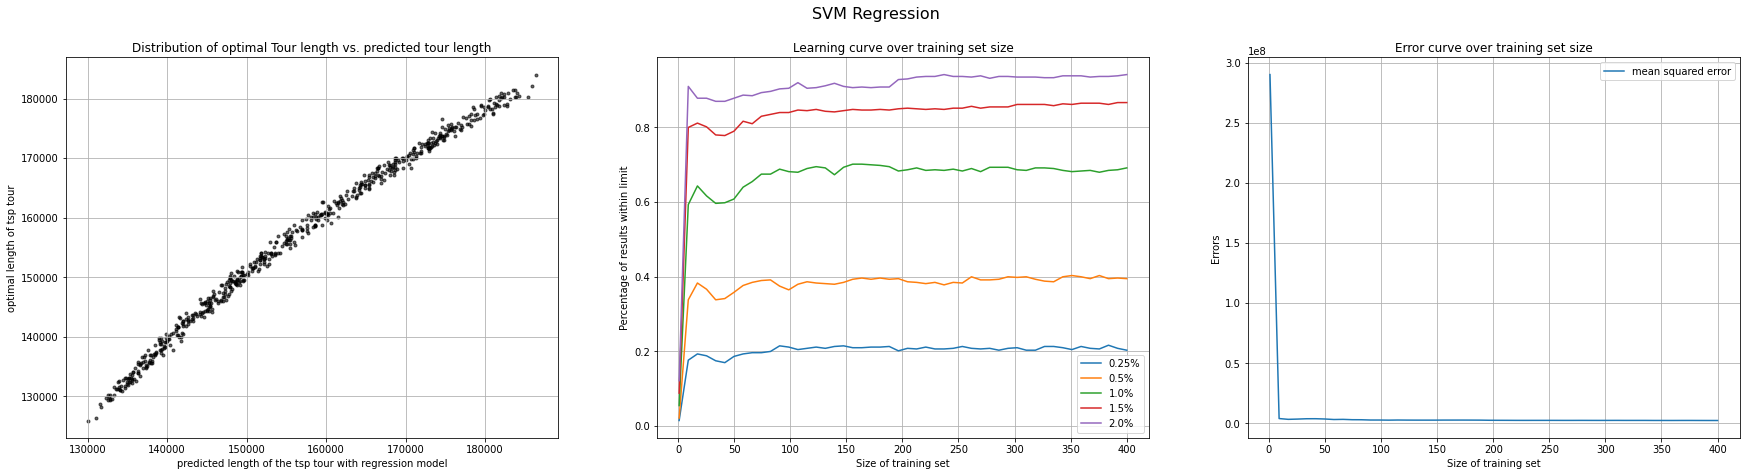

r2_value : 0.9893065236055308


In [111]:
train_set_size, results, errors = rg.get_instances(limits=[0.0025, 0.005, 0.01, 0.015, 0.02])

model = SVR(kernel='poly')

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)
del errors['mean_absolute_error']

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'SVM Regression')
print('r2_value :', r2_score(y_verify, predictions))

## Using clustered Data instead

In [7]:
DIRECTORY_PATH = 'tspset2_heuristics/'

# Get filenames of heuristics and approximation results
cluster_heuristics = {}
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]
#filenames = ['greedy.json', 'mst.json', 'mstheu.json', 'nn.json', 'onetree.json', 'opt.json', ]

for filename in filenames:
    cluster_heuristics[filename.replace('.json', '')] = np.array(fo.load_from_json(DIRECTORY_PATH + filename))


In [8]:
instances = [fo.load_from_json(f'tspset2/ctsp_{i}_sol.json') for i in range(2000)]

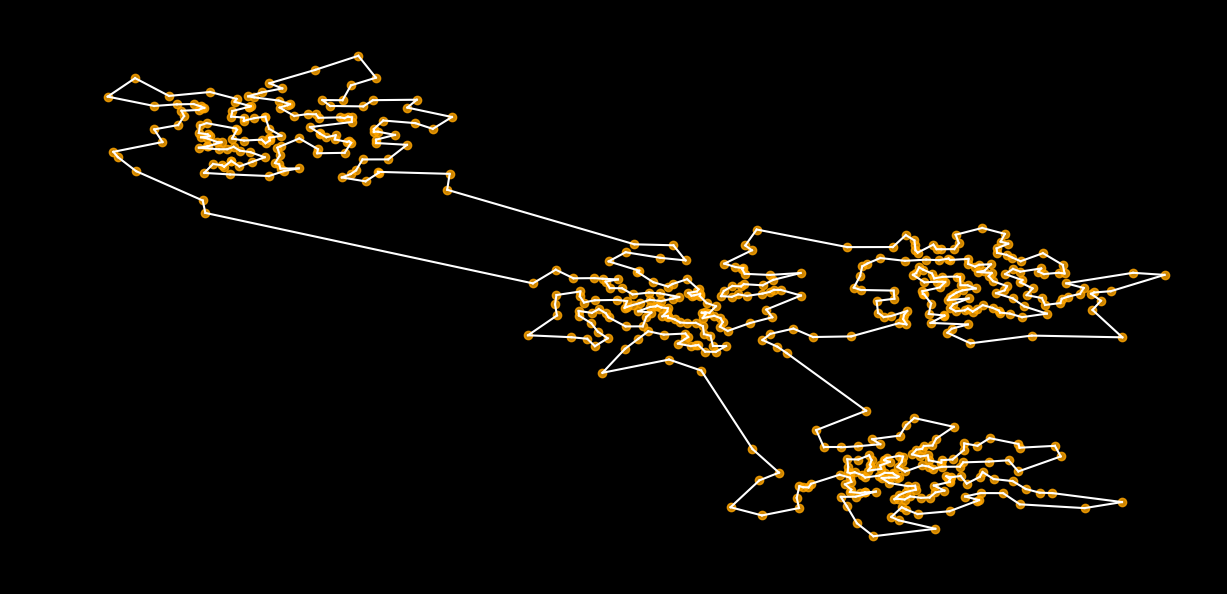

In [9]:
from visualisations import visualise_tour


instance = instances[22]
coordinates = np.array(instance['node_coordinates'])
tour = np.array(instance['tour'])
visualise_tour(coordinates, tour, title='Example Clustered TSP Tour')

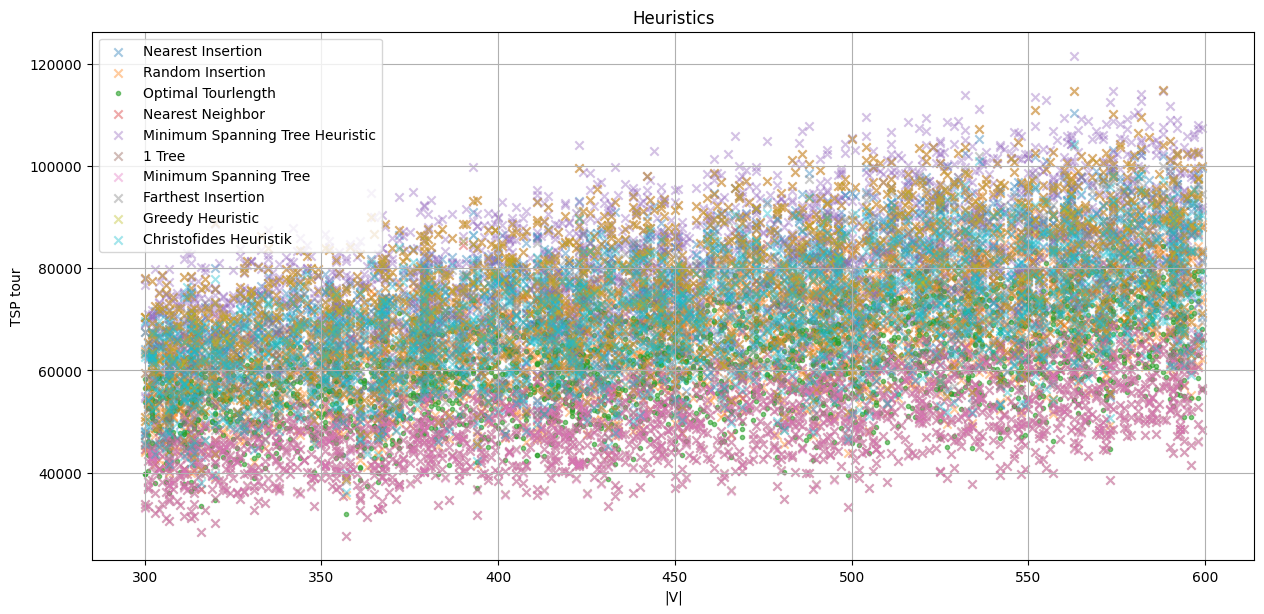

In [20]:
from visualisations import visualise_heuristics

V = [len(x['node_coordinates']) for x in instances]

visualise_heuristics(cluster_heuristics, V)

### Training regression models on clustered data

In [22]:
# moving into DataFrame structure
df_heuristics = pd.DataFrame(cluster_heuristics)

# splitting data
X = df_heuristics.drop(columns=['opt'])
y = df_heuristics['opt']

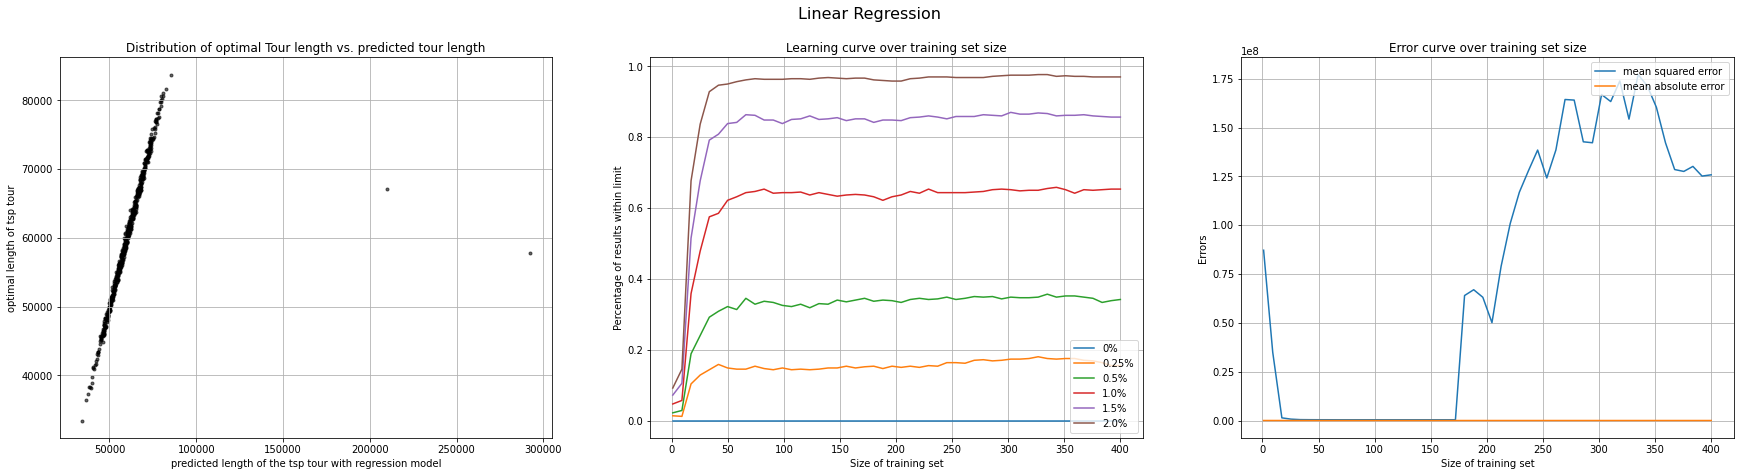

In [23]:
train_set_size, results, errors = rg.get_instances()

model = LinearRegression()

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Linear Regression')

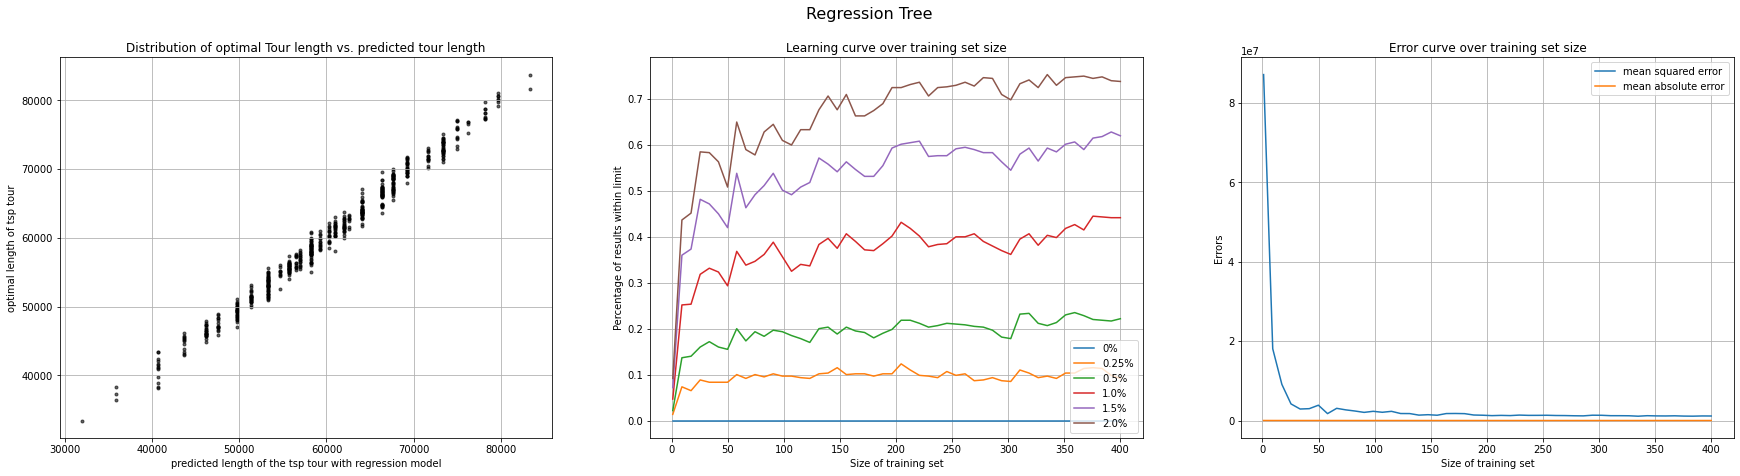

In [24]:
train_set_size, results, errors = rg.get_instances()

model = DecisionTreeRegressor(max_depth=5)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Regression Tree')

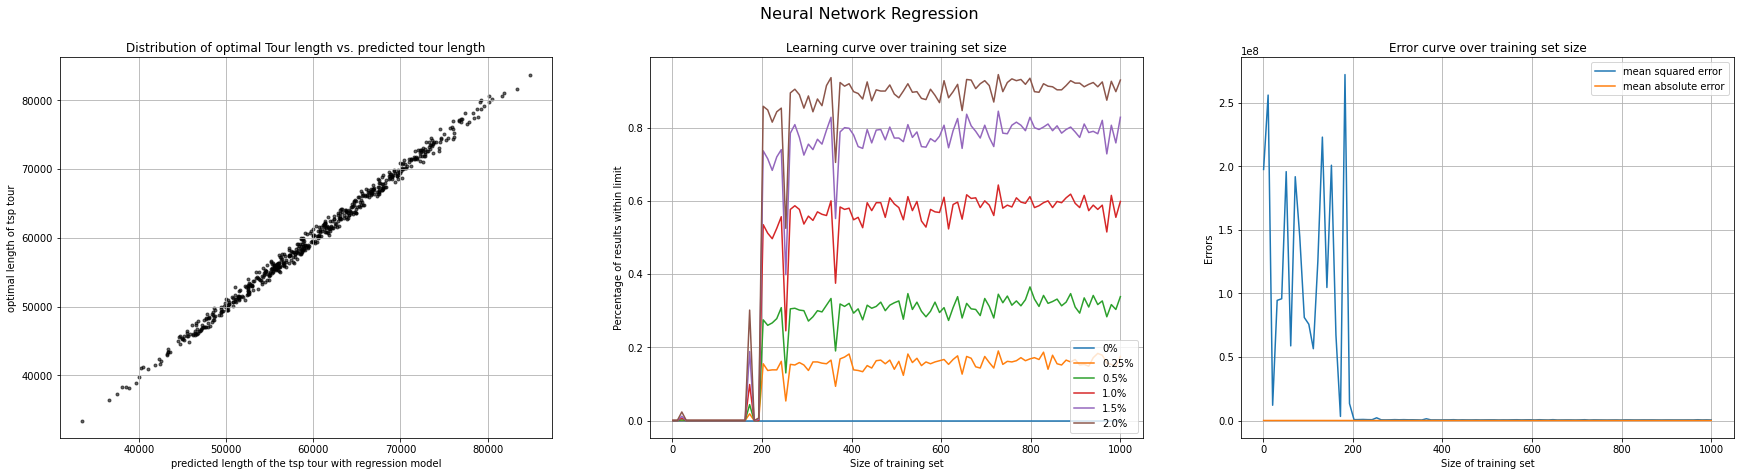

In [25]:
import warnings
warnings.filterwarnings('ignore')

train_set_size, results, errors = rg.get_instances(partition_of_data_set=1/2, number_of_sets=100)

model = MLPRegressor(hidden_layer_sizes=256)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors, test_size=0.3)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Neural Network Regression')

In [55]:
train_set_size, results, errors = rg.get_instances()

model = SVR(kernel='poly')

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'VSM Regression')

ValueError: With n_samples=1000, test_size=0.3 and train_size=0.0005, the resulting train set will be empty. Adjust any of the aforementioned parameters.

# Second Clustered Dataset

In [40]:
DIRECTORY_PATH = 'tspset3_heuristics/'

# Get filenames of heuristics and approximation results
cluster_heuristics = {}
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]
#filenames = ['greedy.json', 'mst.json', 'mstheu.json', 'nn.json', 'onetree.json', 'opt.json', ]

for filename in filenames:
    cluster_heuristics[filename.replace('.json', '')] = np.array(fo.load_from_json(DIRECTORY_PATH + filename))

In [41]:
instances = [fo.load_from_json(f'tspset3/clusterRandom_large_{i}_sol.json') for i in range(1000)]

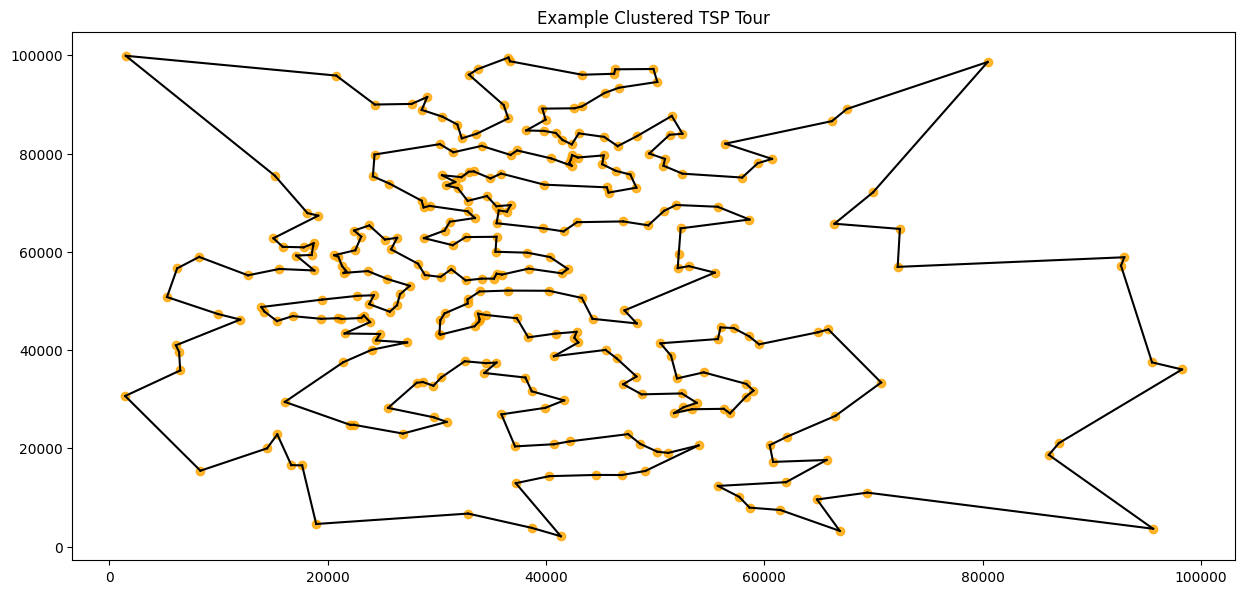

In [42]:
from visualisations import visualise_tour


instance = instances[20]
coordinates = np.array(instance['node_coordinates'])
tour = np.array(instance['tour'])
visualise_tour(coordinates, tour, title='Example Clustered TSP Tour')

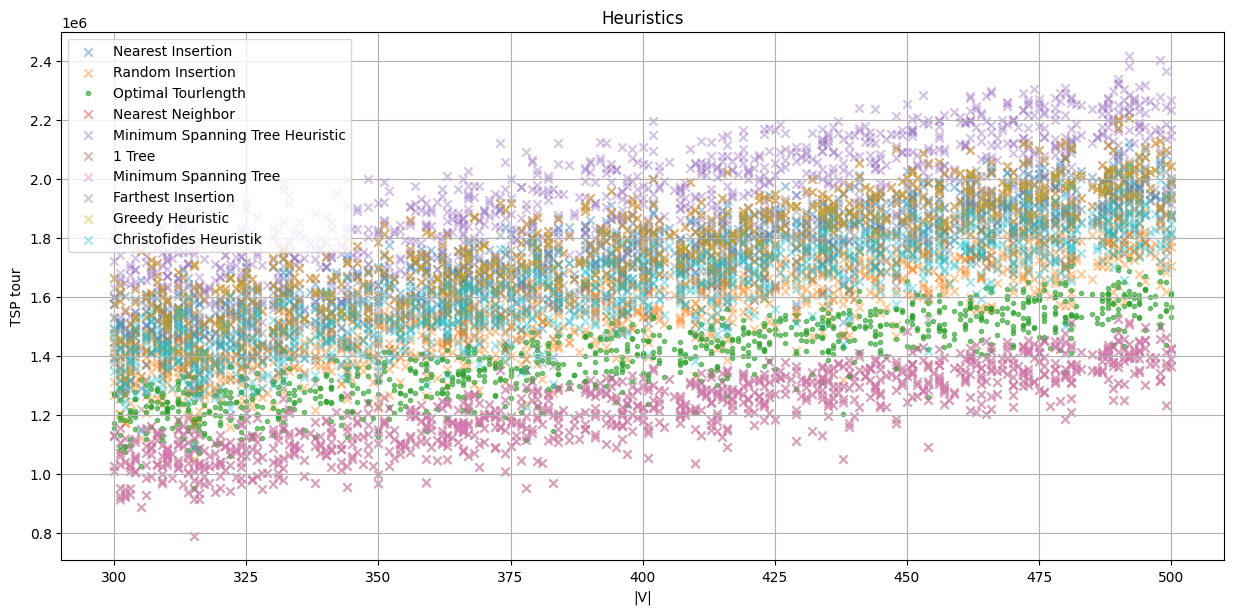

In [43]:
from visualisations import visualise_heuristics

V = [len(x['node_coordinates']) for x in instances]

visualise_heuristics(cluster_heuristics, V)

# TODO recompute the instances with failed Christofides !

In [45]:
# moving into DataFrame structure
df_heuristics = pd.DataFrame(cluster_heuristics)

# splitting data
X = df_heuristics.drop(columns=['opt'])
y = df_heuristics['opt']

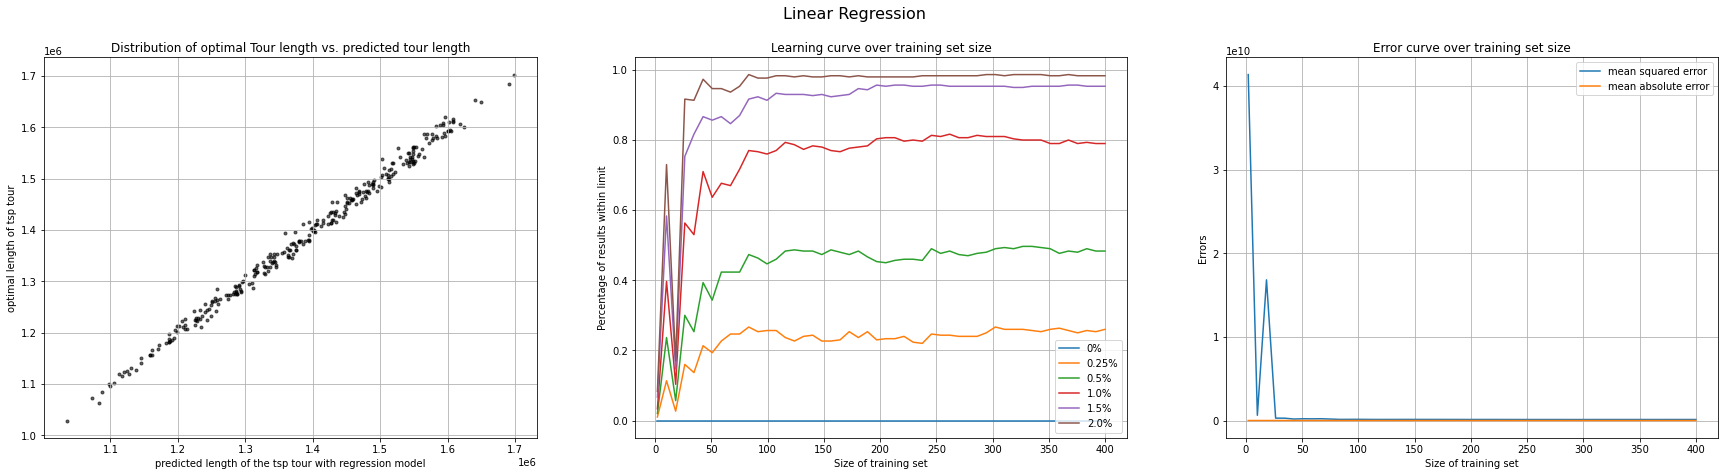

In [47]:
train_set_size, results, errors = rg.get_instances(len_dataset=1000)

model = LinearRegression()

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Linear Regression')

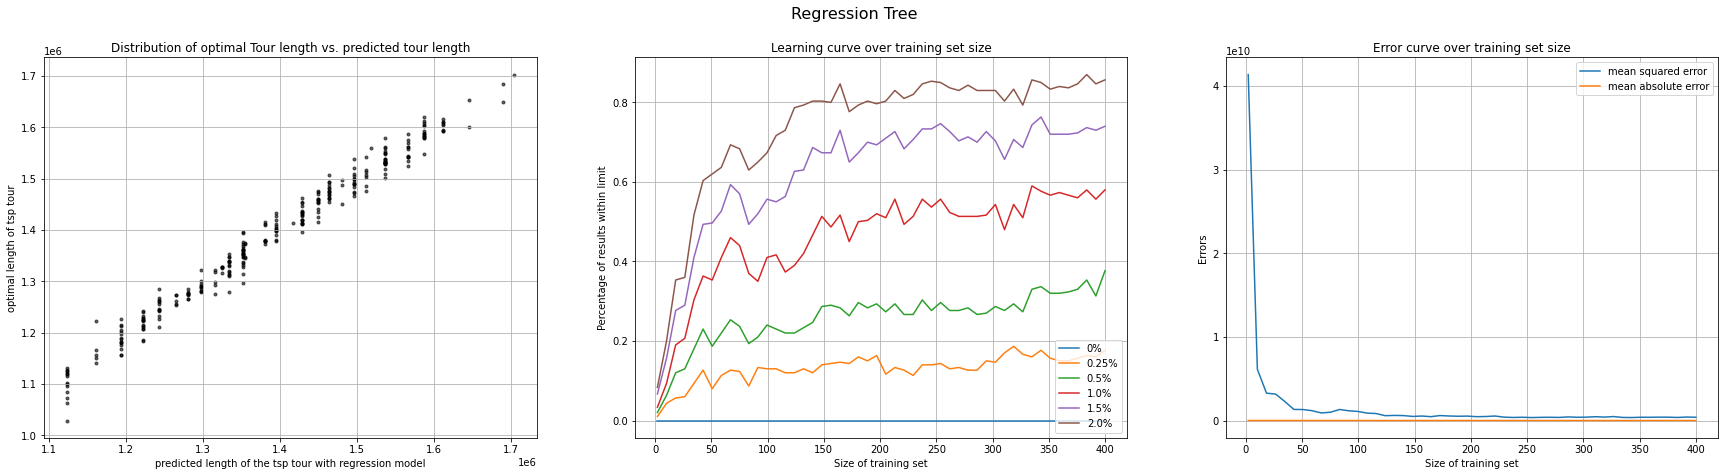

In [49]:
train_set_size, results, errors = rg.get_instances(len_dataset=1000)

model = DecisionTreeRegressor(max_depth=5)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Regression Tree')

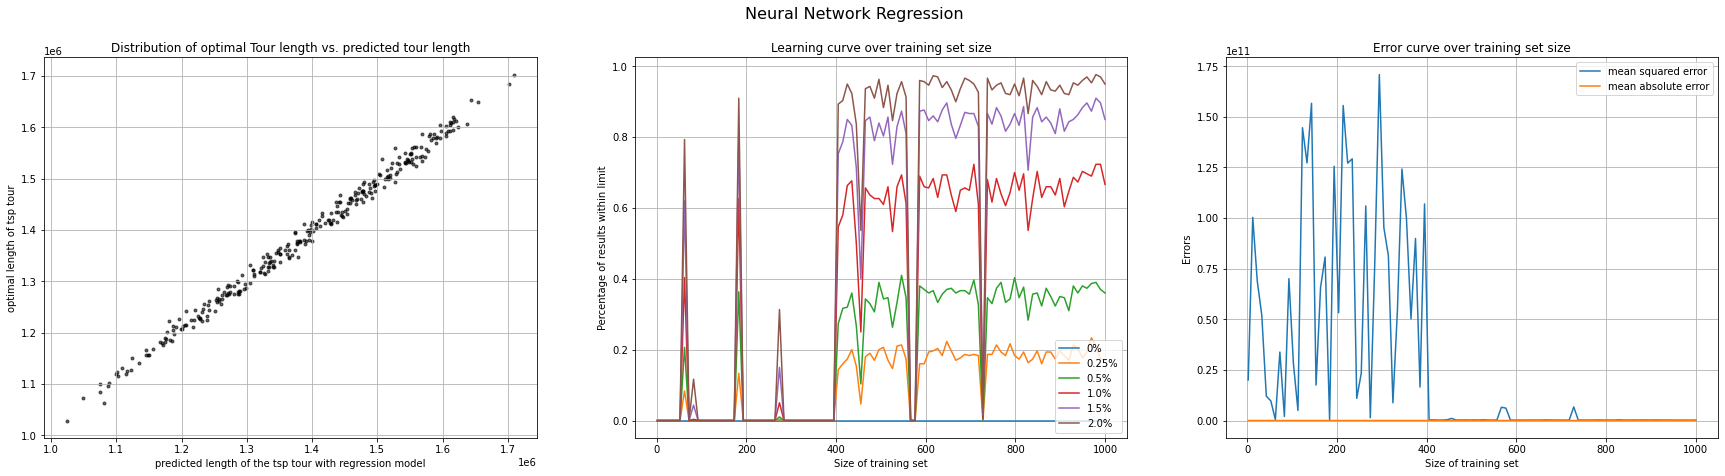

In [50]:
import warnings
warnings.filterwarnings('ignore')

train_set_size, results, errors = rg.get_instances(len_dataset=1000,partition_of_data_set=1/2, number_of_sets=100)

model = MLPRegressor(hidden_layer_sizes=256)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors, test_size=0.3)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Neural Network Regression')

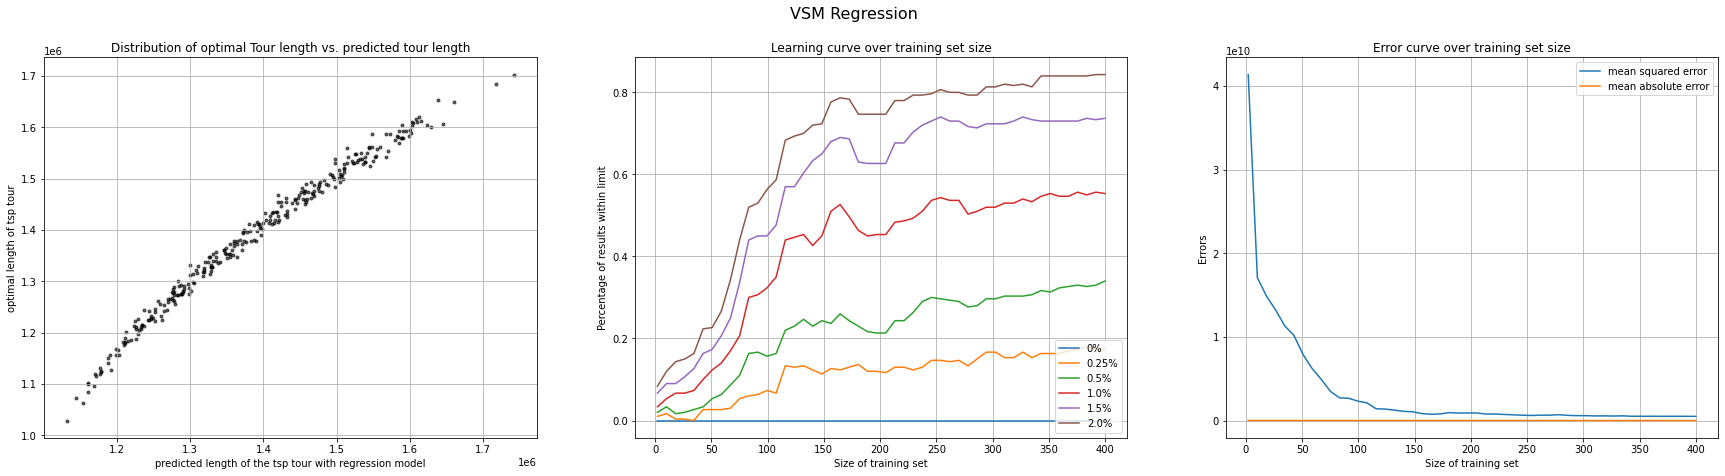

In [57]:
train_set_size, results, errors = rg.get_instances(len_dataset=1000)

model = SVR(kernel='poly')

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'VSM Regression')